# Differential expression analysis of TMT labeled phosphoproteome data using Limma's moderated t-test, Volcano plot
## searched with MaxQuant v.1.6.10.43 with unitprot reviewed mouse DB, without isoforms, with PIF cutoff (0.75) and iBAQ calculation enabled

### Author: Konstantin Kahnert
### Date: 2020_09_15

After determining differentially expressed proteins using the moderated t-test of the LIMMA package, we visualize the results in a volcano plot.

In this script we will:

- create a volcano plot
- create a cluster map of the significant proteins

## Load required packages

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy.stats import gaussian_kde
from adjustText import adjust_text

## Define required functions

In [2]:
def save_figure(fig, name, folder_output):

    # create new path name for saving the figure as pdf
    path_fig = folder_output + "\\" + name + ".pdf"

    # save figure
    plt.savefig(path_fig, bbox_inches="tight")

    # create new path name for saving the figure as png
    path_fig = folder_output + "\\" + name + ".png"

    # save figure
    plt.savefig(path_fig, bbox_inches="tight", dpi=600)

    return None

def plot_clustermap(df, how="short", title="Hierarchical Clustering"):
    """
    Takes data frame, applies hierarchical clustering to columns and plots the resulting clustermap with dendrogram

    input: pandas dataframe (all columns are plotted)
    title= str, title of the plot

    :return: figure
    """
    if how == "short":
        # plot clustermap
        fig = sns.clustermap(df, metric="correlation", cmap="bwr", z_score=0, dendrogram_ratio=(0.4, 0.2),
                             figsize=(8, 10))

        # remove y axis labels (protein names)
        plt.sca(fig.fig.axes[2])
        plt.yticks([])
        plt.ylabel("")

        # rotate x tick labels
        plt.xticks(rotation=45)

        # set title
        fig.ax_col_dendrogram.set_title(title, weight="bold")

    elif how == "long":
        # plot clustermap
        fig = sns.clustermap(df, metric="correlation", cmap="bwr", z_score=0, dendrogram_ratio=(0.4, 0.05),
                             figsize=(8, 48))

        # remove y axis labels (protein names)
        plt.sca(fig.fig.axes[2])
        # plt.yticks([])
        # plt.ylabel("")
        ax = plt.gca()
        ax.set_yticks(np.arange(len(df))+0.5)
        ax.set_yticklabels(df.index)
        ax.tick_params(axis='y', which='both', width= 0.5, length= 2, labelsize=5)
        plt.yticks(va="center")
        # rotate x tick labels
        plt.xticks(rotation=45)

        # set title
        fig.ax_col_dendrogram.set_title(title, weight="bold")

    else:
        raise ValueError("The parameter \"how\" can either be \"long\" or \"short\"")

    return fig


##  Specify significance cutoffs

In [3]:
q_cutoff = 0.05
fc_cutoff = 1.3
annotate = True

## Specify proteins to annotate

In [4]:
to_annotate = ["Kcnh2", "Pfkm", "Mylk", "Plm", "Gja1", "Ryr2", "Akap8", "Myl7", "Mybpc3", "Myh6", "Slc9a1", "Gys1", "Cryab", "Prkab1", "Prka2", "Prkg1", "Tfeb",
               "Camk2d", "Tmem38a", "Trpm7", "Stim1", "Msr1", "Naca", "Akap2", "Akapl2"]

## Specify imput file location

In [5]:
path_ttest_results = r"E:\Data\Heart_failure_mice_CS\Sinus_node\Phosphoproteome\Analysis\03_volcano_plot_analysis\phosphosites(STY)_proteome_ratio_norm _empBayes_pvals.csv"


## Set path for output

In [6]:
folder_output = "".join(re.findall("[^\\\\]+\\\\", path_ttest_results))

## Load file to pandas data frame

In [7]:
df_ttest = pd.read_csv(path_ttest_results)
df_ttest.head(5)

,logFC,t.ord,t.mod,p.ord,p.mod,q.ord,q.mod,df.r,df.0,s2.0,...,Leading.proteins,Protein,Protein.names,Gene.names,Sequence.window,Modification.window,Phospho..STY..Probabilities,id,Unique.identifier,Number.of.Phospho..STY.
0,0.358409,2.453654,2.626226,0.039710,0.023798,0.074865,0.052195,8,2.855463,0.027567,...,P0DPB4,P0DPB4,NaN,Schip1,DADDSKTETSLDTPLSPMSKQSSSYSDRDTT,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;...,TETSLDT(0.001)PLS(0.995)PMS(0.005)K,1,UID2,1
1,-0.194089,-1.181582,-1.285806,0.271302,0.225261,0.227756,0.197527,8,2.855463,0.027567,...,A2A5R2,A2A5R2,Brefeldin A-inhibited guanine nucleotide-excha...,Arfgef2,GKVSLENGEAPRERGSPVSGRAEPSRGTDSG,X;X;X;Phospho (STY);X;X;X;X;X;X;X;X;X;X;X;Phos...,GS(1)PVSGR,3,UID4,1
2,-0.432227,-3.842148,-3.908873,0.004932,0.002500,0.024330,0.015073,8,2.855463,0.027567,...,A2A5R2,A2A5R2,Brefeldin A-inhibited guanine nucleotide-excha...,Arfgef2,MQSKPQSPVIQATAGSPKFSRLKQSQAQSKP,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;...,PQSPVIQAT(0.025)AGS(0.975)PK,6,UID7,1
3,0.091777,0.533685,0.584026,0.608064,0.571139,0.355374,0.333924,8,2.855463,0.027567,...,A2A5R2,A2A5R2,Brefeldin A-inhibited guanine nucleotide-excha...,Arfgef2,NSQTNGIADDRQSLSSADNLEPDVQGHQVAA,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;...,QS(0.002)LS(0.117)S(0.881)ADNLEPDVQGHQVAAR,7,UID8,1
4,-0.081944,-0.910456,-0.870058,0.389190,0.403098,0.277106,0.274317,8,2.855463,0.027567,...,A2A5R2,A2A5R2,Brefeldin A-inhibited guanine nucleotide-excha...,Arfgef2,ELPNGDHAQSGLGKVSLENGEAPRERGSPVS,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;...,VS(1)LENGEAPR,8,UID9,1


## Rename columns (replace . by space)

In [8]:
df_ttest.columns = df_ttest.columns.str.replace(".", " ")

C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


## Add -log10(p.mod) column

In [9]:
df_ttest["-log10(p mod)"] = df_ttest["p mod"].apply(np.log10).apply(np.negative)

## Add gene name column with first gene of gene names column

In [10]:
df_ttest["Gene name"] = df_ttest["Gene names"].apply(lambda x: str(x).split(";")[0])

## Set gene names as index

In [12]:
df_ttest.set_index("Gene name", inplace=True)

## Calculate log2 fc cutoffs

In [13]:
log_fc_cutoff = np.log2(fc_cutoff)

## Get -log10 p-value cutoff (moderated largest moderated p value of subset q value> 0.05)

In [14]:
# get significant proteins based on q value cutoff
df_signif_q = df_ttest[df_ttest["q mod"] < q_cutoff]

# sort dataframe by q values and get p value of the protein with the highest q value
p_cutoff = df_signif_q.sort_values("q mod").iloc[-1, :]["p mod"]

# calculate -log10 p value cutoff
log_p_cutoff = -np.log10(p_cutoff)

## Get significant proteins

In [15]:
df_signif_q

,logFC,t ord,t mod,p ord,p mod,q ord,q mod,df r,df 0,s2 0,...,Protein,Protein names,Gene names,Sequence window,Modification window,Phospho STY Probabilities,id,Unique identifier,Number of Phospho STY,-log10(p mod)
Gene name,,,,,,,,,,,,,,,,,,,,,
Arfgef2,-0.432227,-3.842148,-3.908873,0.004932,0.002500,0.024330,0.015073,8,2.855463,0.027567,...,A2A5R2,Brefeldin A-inhibited guanine nucleotide-excha...,Arfgef2,MQSKPQSPVIQATAGSPKFSRLKQSQAQSKP,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;...,PQSPVIQAT(0.025)AGS(0.975)PK,6,UID7,1,2.602042
Tanc2,-0.513399,-5.095735,-5.038855,0.000935,0.000394,0.010129,0.005797,8,2.855463,0.027567,...,A2A690,Protein TANC2,Tanc2,GSHQVFDFRSNSSVGSPTRQGYQSTSPALSP,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;...,SNSSVGS(0.999)PT(0.001)R,9,UID10,1,3.404112
Tanc2,-0.427821,-2.715599,-2.938881,0.026428,0.013650,0.059656,0.038032,8,2.855463,0.027567,...,A2A690,Protein TANC2,Tanc2,SPPAESMSVYRSQSGSPVRYQQETNVSQLPG,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;...,SQS(0.002)GS(0.998)PVR,10,UID11,1,1.864865
Zmym4,-0.369263,-8.019930,-5.527494,0.000043,0.000187,0.002126,0.003890,8,2.855463,0.027567,...,A2A791,Zinc finger MYM-type protein 4,Zmym4,TDGSLEVERRAAHQESDNENEIQIQNQLKKD,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;...,AAHQES(1)DNENEIQIQNQLK,12,UID13,1,3.727140
Kiaa1109,0.255704,3.423304,3.053568,0.009044,0.011134,0.033349,0.034074,8,2.855463,0.027567,...,A2AAE1,Uncharacterized protein KIAA1109,Kiaa1109,DRYVHASKMQPQSSGSLRSNAGAEKGKEIAA,X;X;X;X;X;X;X;X;Oxidation (M);X;X;X;X;X;X;Phos...,MQPQSS(0.001)GS(0.999)LR,19,UID20,1,1.953346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rps14,-0.707824,-7.693626,-7.404434,0.000058,0.000015,0.002253,0.001011,8,2.855463,0.027567,...,P62264,40S ribosomal protein S14,Rps14,KIGRIEDVTPIPSDSTRRKGGRRGRRL____,X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;Phosph...,IEDVT(0.649)PIPS(0.784)DS(0.784)T(0.784)RR,6602,UID21187,3,4.835647
Scn9a,0.431189,6.308941,5.414038,0.000231,0.000222,0.004785,0.004318,8,2.855463,0.027567,...,Q62205,Sodium channel protein type 9 subunit alpha,Scn9a,DPHLRQRAMSRASILTNTVEELEESRQKCPP,X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;X;Phos...,AS(1)ILT(1)NT(1)VEELEES(0.001)R,6814,UID21399,3,3.653449
Scn9a,0.431189,6.308941,5.414038,0.000231,0.000222,0.004785,0.004318,8,2.855463,0.027567,...,Q62205,Sodium channel protein type 9 subunit alpha,Scn9a,HLRQRAMSRASILTNTVEELEESRQKCPPWW,X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;X;Phospho ...,AS(1)ILT(1)NT(1)VEELEES(0.001)R,6815,UID21400,3,3.653449


In [16]:
df_signif = df_signif_q[df_signif_q["logFC"].abs() > log_fc_cutoff]

## Split by positive and negatice fold change

In [17]:
df_signif_pos = df_signif[df_signif["logFC"] > 0]
df_signif_neg = df_signif[df_signif["logFC"] < 0]

## Get number of significant proteins

In [18]:
num_sign_up = len(df_signif_pos)
num_sign_down = len(df_signif_neg)
num_sign = num_sign_up + num_sign_down

## Save dataframe as xlsx file

In [19]:
with pd.ExcelWriter(path_ttest_results[:-4] + "_vp.xlsx") as writer:
    df_ttest.to_excel(writer, sheet_name='All', index=False)
    df_signif_q.to_excel(writer, sheet_name='q<0.05', index=False)
    df_signif.to_excel(writer, sheet_name='q<0.05+FC>1.3', index=False)
    df_signif_neg.to_excel(writer, sheet_name='signif. decreased', index=False)
    df_signif_pos.to_excel(writer, sheet_name='signif. increased', index=False)

# Volcano plot

## Extract all proteins that should be annotated

In [44]:
df_annotate = df_signif.reset_index()[df_signif.reset_index()["Gene name"].isin(to_annotate)]
df_annotate.set_index("Gene name", inplace=True)

## Create scatter plot with -log10(p-values) on Y axis and log2(difference) on X axis

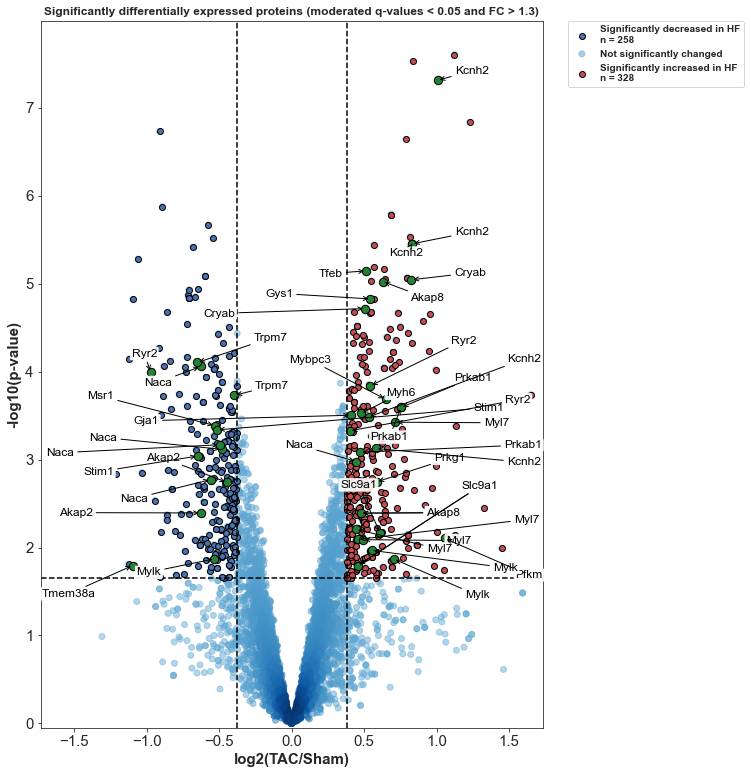

In [47]:
# Calculate the point density
xy = np.vstack([df_ttest["logFC"], df_ttest["-log10(p mod)"]])
z = gaussian_kde(xy)(xy)

# get blues colormap and reduce dynamic range (only go from medium dark to dark)
Blues = cm.get_cmap("Blues", 512)
Blues_new = ListedColormap(Blues(np.linspace(0.5, 1, 256)))

# set plot background to plain whit
sns.set_style("white")

# initiate new figure
fig, ax = plt.subplots(figsize=(9, 13))

# create scatter plot of all values colored by density (will be the seen for the unsignificant proteins later)
ax.scatter(x="logFC",
           y="-log10(p mod)",
           data=df_ttest,
           edgecolor=None,
           c=z,
           cmap=Blues_new,
           alpha=0.5,
           label="Not significantly changed")

# plot significant proteins with positive fold change in red on top of the density scatter plot
ax.scatter(x="logFC",
           y="-log10(p mod)",
           data=df_signif_pos,
           edgecolor="k",
           color="#C44E52",
           label="Significantly increased in HF\nn = " + str(num_sign_up))

# plot significant proteins with negative fold change in red on top of the density scatter plot
ax.scatter(x="logFC",
           y="-log10(p mod)",
           data=df_signif_neg,
           edgecolor="k",
           color="#4C72B0",
           label="Significantly decreased in HF\nn = " + str(num_sign_down))

if annotate == True:
    # plot proteins that should be annotated
    ax.scatter(x="logFC",
               y="-log10(p mod)",
               data=df_annotate,
               edgecolor="k",
               color="#238332",
               s=70)
else:
    pass

# set axis limit
x_limit = max(abs(min(df_ttest["logFC"])), max(df_ttest["logFC"])) * 1.05
plt.xlim(-x_limit, x_limit)

y_limit_upper = df_ttest["-log10(p mod)"].max() * 1.05
y_limit_lower = -0.05
plt.ylim(y_limit_lower, y_limit_upper)

# draw line at p-value cutoff
plt.plot([-x_limit, x_limit], [log_p_cutoff, log_p_cutoff], linestyle="dashed", color="black")

# draw line for fold change cutoff
plt.plot([-log_fc_cutoff, -log_fc_cutoff], [-0.05, y_limit_upper], linestyle="dashed", color="black")
plt.plot([log_fc_cutoff, log_fc_cutoff], [-0.05, y_limit_upper], linestyle="dashed", color="black")

if annotate == True:
    # get texts for annotation
    texts = []
    for line in range(len(df_annotate)):
        texts.append(plt.text(df_annotate["logFC"][line], df_annotate["-log10(p mod)"][line],
                              df_annotate.index[line], horizontalalignment='left', size='large', color='black',
                              bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, pad=0.1)))

    # adjust text to avoid overlapping with arrows
    # adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

    # adjust text to avoid overlapping with arrows
    X = list(df_ttest["logFC"])
    Y = list(df_ttest["-log10(p mod)"])
    adjust_text(texts, x=X, y=Y, expand_points=(2, 2), expand_text=(2, 2), expand_align=(1.05, 1.2),
                force_text=0.5, force_points=0.5, precision=0.00001,
                arrowprops=dict(arrowstyle='->', color='black'))

else:
    pass

# get legend handelsa and labels
handles, labels = ax.get_legend_handles_labels()

# add axis labels
plt.xlabel("log2(TAC/Sham)", weight="bold", fontsize=15)
plt.ylabel("-log10(p-value)", weight="bold", fontsize=15)

# add tick marks
ax.tick_params(axis='both', which='major', direction="out", reset=True, right=False, top=False, labelsize=15)

# add title
plt.title("Significantly differentially expressed proteins (moderated q-values < 0.05 and FC > 1.3)", weight="bold")

# create legend stating number of significantly up and down as well as total number of diff. regulated proteins
legend_elements = [handles[2],
                   handles[0],
                   handles[1]]

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
          prop={'size': 10, "weight": "bold"})

# save figure
name = "volcanoplot_limma"
save_figure(fig, name, folder_output)

# show figure
plt.show()

,logFC,t ord,t mod,p ord,p mod,q ord,q mod,df r,df 0,s2 0,...,Protein,Protein names,Gene names,Sequence window,Modification window,Phospho STY Probabilities,id,Unique identifier,Number of Phospho STY,-log10(p mod)
Gene name,,,,,,,,,,,,,,,,,,,,,
Ryr2,0.402197,5.625863,4.925735,4.951070e-04,4.707280e-04,0.007204,0.006316,8,2.855463,0.027567,...,E9Q401,Ryanodine receptor 2,Ryr2,ESNYVSMMEKQSSMDSEGNFNPQPVDTSNIT,X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);Phospho (S...,QS(0.276)S(0.742)MDS(0.981)EGNFNPQPVDTSNITIPEK,297,UID287,1;2,3.327230
Ryr2,-0.972843,-5.406247,-5.946567,6.412210e-04,1.017390e-04,0.008333,0.002594,8,2.855463,0.027567,...,E9Q401,Ryanodine receptor 2,Ryr2,RFLLRRTKPDYSTGHSARLTEDVLADDRDDY,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;...,TKPDYSTGHS(1)AR,298,UID288,1,3.992513
Kcnh2,0.583023,4.403383,4.635367,2.276439e-03,7.476550e-04,0.016523,0.007985,8,2.855463,0.027567,...,O35219,Potassium voltage-gated channel subfamily H me...,Kcnh2,RTRSRESCASVRRASSADDIEAMRAGALPPP,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;...,AS(0.019)S(0.981)ADDIEAMR,460,UID450,1,3.126299
Kcnh2,1.008772,16.050561,13.232622,2.280000e-07,4.880000e-08,0.000152,0.000043,8,2.855463,0.027567,...,O35219,Potassium voltage-gated channel subfamily H me...,Kcnh2,LEITFNLRDTNMIPGSPGSAELESGFNRQRK,X;X;X;X;X;X;X;X;X;X;X;Oxidation (M);X;X;X;Phos...,DT(0.007)NMIPGS(0.993)PGS(0.999)AELESGFNR,461,UID451,1;2,7.311580
Kcnh2,0.530549,5.196408,5.157345,8.260170e-04,3.282490e-04,0.009430,0.005174,8,2.855463,0.027567,...,O35219,Potassium voltage-gated channel subfamily H me...,Kcnh2,TGAMHPLRSGLLNSTSDSDLVRYRTISKIPQ,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;...,SGLLNST(0.032)S(0.957)DS(0.011)DLVR,463,UID453,1,3.483797
Akap2,-0.627591,-3.278904,-3.629518,1.120613e-02,4.044301e-03,0.037407,0.019846,8,2.855463,0.027567,...,O54931,A-kinase anchor protein 2,Akap2,GSEKPQGMFAPPQVSSPVQEKRDILPKNLPA,X;X;X;X;X;X;X;Oxidation (M);X;X;X;X;X;X;X;Phos...,PQGMFAPPQVS(0.181)S(0.819)PVQEK,550,UID540,1,2.393157
Akap2,-0.447445,-4.043516,-4.097484,3.717541e-03,1.815776e-03,0.021220,0.012839,8,2.855463,0.027567,...,O54931,A-kinase anchor protein 2,Akap2,YKTAPGKIEKVKPPPSPTTEGPSLQPDLAPE,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;...,VKPPPS(0.748)PT(0.25)T(0.002)EGPSLQPDLAPEEAAGTQR,553,UID543,1,2.740938
Prkg1,0.586648,3.805138,4.105608,5.198484e-03,1.791106e-03,0.024776,0.012735,8,2.855463,0.027567,...,P0C605,cGMP-dependent protein kinase 1,Prkg1,HTEYMEFLKSVPTFQSLPDEILSKLADVLEE,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;...,SVPTFQS(1)LPDEILSK,827,UID817,1,2.746879
Gja1,0.408584,6.104381,5.188136,2.880770e-04,3.130670e-04,0.005344,0.005019,8,2.855463,0.027567,...,P23242,Gap junction alpha-1 protein,Gja1,GHELQPLAIVDQRPSSRASSRASSRPRPDDL,X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);Phos...,VAAGHELQPLAIVDQRPS(0.75)S(0.75)RAS(0.75)S(0.75)R,1045,UID1035,1;3,3.504363


# Cluster map

In [20]:
# get normalized intensities of the significant proteins
df_signif_clustermap = df_signif.filter(regex="(TAC)|(Sham)")

df_signif_clustermap

,Sham 1,Sham 2,Sham 3,Sham 4,Sham 5,TAC 1,TAC 2,TAC 3,TAC 4,TAC 5
Gene name,,,,,,,,,,
Arfgef2,0.264663,0.602154,0.321928,0.175651,0.087805,-0.266028,-0.182583,-0.112253,0.116878,-0.264947
Tanc2,-1.197244,-1.333478,-1.446914,-1.502809,-1.133252,-1.756743,-1.994314,-2.009809,-1.639027,-1.780799
Tanc2,-0.798458,-1.108549,-1.019587,-1.126466,-0.773291,-1.800204,-1.320698,-1.561051,-0.973364,-1.310137
Kiaa1109,-1.343762,-1.370656,-1.562417,-1.613200,-0.769139,-0.821725,-0.873444,-0.505113,-0.525988,-0.849898
Camsap1,-1.989369,-1.918738,-2.286439,-2.105859,-2.078466,-1.400553,-1.847684,-1.523301,-1.745139,-1.679030
...,...,...,...,...,...,...,...,...,...,...
Rps14,1.883250,1.714031,1.675224,1.462198,1.591773,0.800707,0.849375,1.123629,1.051056,0.962591
Scn9a,0.084981,0.191568,0.271920,0.386398,0.176549,0.689601,0.595058,0.815611,0.557542,0.609550
Scn9a,0.084981,0.191568,0.271920,0.386398,0.176549,0.689601,0.595058,0.815611,0.557542,0.609550


## Plot clustermaps in a long and a short version

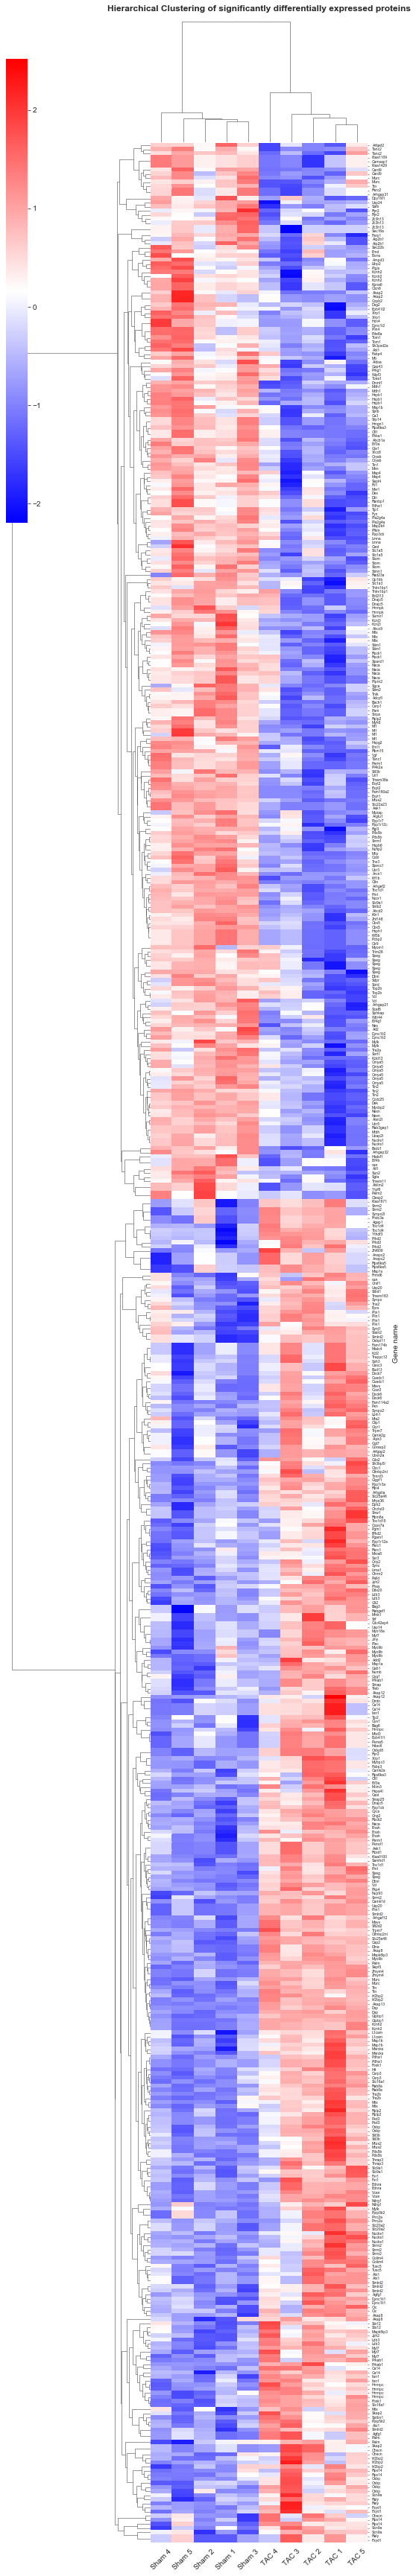

In [21]:
# plot clustermap of significant proteins
fig_clustermap = plot_clustermap(df_signif_clustermap, how="long",
                                 title="Hierarchical Clustering of significantly differentially expressed proteins")

# save figure
name = "clustermap_signif_FC_1.3_prot_limma_long"
save_figure(fig_clustermap, name, folder_output)

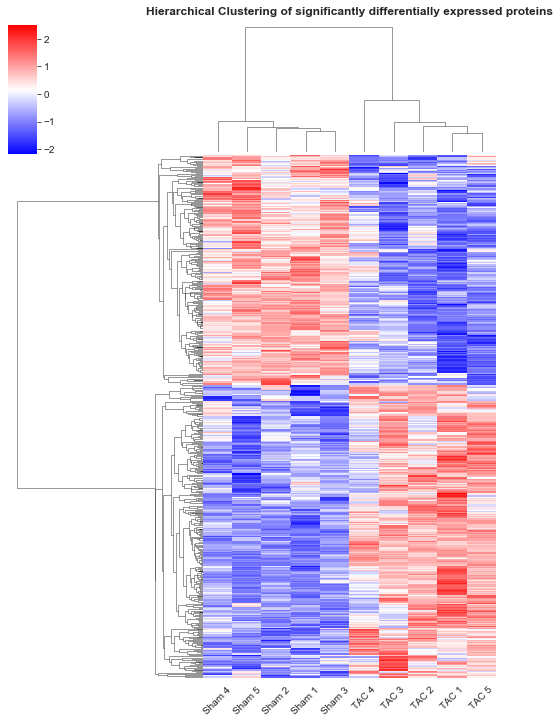

In [22]:
# plot clustermap of significant proteins
fig_clustermap = plot_clustermap(df_signif_clustermap, how="short",
                                 title="Hierarchical Clustering of significantly differentially expressed proteins")

# save figure
name = "clustermap_signif_FC_1.3_prot_limma_short"
save_figure(fig_clustermap, name, folder_output)